# **뇌종양 MRI 이미지 분류 프로젝트**

## **1. 프로젝트 개요**
- 본 프로젝트는 **뇌종양 MRI 데이터를 활용하여 이미지 분류 모델을 개발**하는 것을 목표로 합니다.
- **CNN(Convolutional Neural Network)** 기반으로 3가지 모델(`BasicCNN`, `IntermediateCNN`, `AdvancedCNN`)을 설계하고 성능을 비교 분석합니다.
- 데이터셋은 **Kaggle**에서 제공하는 `brain-tumor-mri-data`를 사용합니다.

---

## **2. 프로젝트 흐름**
### 🔹 **데이터 처리 및 준비**
- **Kaggle API**를 이용해 MRI 데이터 다운로드 및 전처리 수행.
- **`transforms`**를 활용한 이미지 변환(크기 조정, 텐서 변환, 정규화).

### 🔹 **모델 설계 및 학습**
- **BasicCNN** → 간단한 CNN 구조.
- **IntermediateCNN** → 중간 복잡도의 CNN 모델.
- **AdvancedCNN** → 더 깊은 구조를 가진 고급 CNN 모델.
- 모델 학습 시 **조기 종료(Early Stopping)** 및 `Adam` 옵티마이저 적용.

### 🔹 **모델 평가 및 성능 비교**
- **Accuracy, Precision, Recall, F1-score**를 활용한 성능 분석.
- 학습된 모델을 평가하고 **최적 모델을 선택**.
- **CSV 파일로 결과 저장** 및 **그래프 시각화**.

---

## **3. 사용된 주요 라이브러리**
- **`torch`, `torchvision`** → 딥러닝 모델 구축 및 이미지 데이터 처리.
- **`pandas`** → 모델 평가 결과 저장 및 CSV 변환.
- **`matplotlib`** → 성능 시각화 (모델별 비교 그래프).
- **`sklearn.metrics`** → 모델 성능 평가 (정확도, 정밀도, 재현율, F1-score).

# Google Colab에서 Kaggle API 인증을 위한 파일 업로드

Google Colab에서 Kaggle API를 사용하려면 `kaggle.json` 인증 파일을 업로드해야 합니다.

In [1]:
from google.colab import files
files.upload()  # kaggle.json 파일 업로드


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mldlmaster","key":"51f5b87821365b75d176d077592a6593"}'}

# Kaggle API 인증 설정

- Kaggle API를 사용하기 위해 `kaggle.json` 파일을 지정된 폴더로 이동하고 보안 권한을 설정함.
- 파일 권한을 조정하여 안전한 인증 환경을 구성함.


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# Kaggle 데이터셋 다운로드

- `kaggle.json` 인증을 완료한 후 Kaggle API를 통해 데이터셋을 다운로드함.
- `tombackert/brain-tumor-mri-data` 데이터셋을 현재 작업 디렉토리로 저장.


In [3]:
!kaggle datasets download -d tombackert/brain-tumor-mri-data


Dataset URL: https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data
License(s): MIT
 98% 149M/151M [00:04<00:00, 41.4MB/s]
100% 151M/151M [00:04<00:00, 37.7MB/s]


In [5]:
import os
os.listdir("brain_tumor_data")


['brain-tumor-mri-dataset']

# PyTorch 기반 딥러닝 환경 설정

- `torch`, `torch.nn`, `torch.nn.functional` → 신경망 모델 구성 및 손실 함수 정의.
- `torch.optim` → 최적화 알고리즘 사용.
- `torchvision.datasets`, `torchvision.transforms` → 이미지 데이터셋 로드 및 전처리.
- `torch.utils.data.DataLoader`, `random_split` → 데이터 배치 및 훈련/검증 세트 분할.
- `numpy` → 수치 연산을 위한 배열 처리.
- `copy` → 모델 복사 및 가중치 저장을 위한 라이브러리.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import copy


# 이미지 데이터 변환 (전처리)

- `Resize((224, 224))` → 모든 이미지를 224x224 크기로 조정.
- `ToTensor()` → 이미지를 PyTorch Tensor 형식으로 변환.
- `Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])` → 픽셀 값을 [-1, 1] 범위로 정규화.


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # PyTorch Tensor로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])


# 데이터셋 로드

- `data_dir` → 이미지 데이터가 저장된 디렉토리 경로 설정.
- `datasets.ImageFolder` → 폴더 구조에 따라 라벨을 자동으로 지정하여 데이터셋 생성.
- `transform=transform` → 데이터셋에 정의된 변환(전처리) 적용.


In [8]:
data_dir = '/content/brain_tumor_data/brain-tumor-mri-dataset'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


# 데이터셋 분할

- 전체 데이터셋의 크기를 확인하고 훈련(60%), 검증(20%), 테스트(20%) 세트로 분할.
- `random_split()`을 사용하여 데이터셋을 무작위로 나눔.
- 각 데이터셋의 크기를 출력하여 확인.


In [9]:
# 데이터셋 크기
dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)  # 60%
val_size = int(dataset_size * 0.2)    # 20%
test_size = dataset_size - train_size - val_size  # 나머지

# 랜덤 분할
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train set: {len(train_dataset)}개")
print(f"Validation set: {len(val_dataset)}개")
print(f"Test set: {len(test_dataset)}개")


Train set: 4291개
Validation set: 1430개
Test set: 1432개


# 데이터 로더 설정

- `batch_size = 128` → 한 번에 처리할 데이터 샘플 개수 설정.
- `DataLoader`를 사용하여 데이터 배치 로딩 및 병렬 처리 최적화.
  - `shuffle=True` (훈련 데이터) → 모델 학습의 일반화 성능 향상을 위해 랜덤 섞기.
  - `shuffle=False` (검증 및 테스트 데이터) → 일정한 순서 유지.
  - `num_workers=2` → 데이터 로딩 속도 향상을 위한 병렬 처리 설정.
- 훈련, 검증, 테스트 세트의 크기를 출력하여 확인.


In [10]:
# 배치 크기 설정
batch_size = 128

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)  # 학습 데이터 (랜덤 섞기)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)  # 검증 데이터 (순서 유지)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)  # 테스트 데이터 (순서 유지)

# 데이터 크기 확인
print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")


Train set: 4291 samples
Validation set: 1430 samples
Test set: 1432 samples


In [11]:
# 첫 번째 배치 데이터 확인
train_images, train_labels = next(iter(train_loader))

# 배치 크기 및 이미지 크기 출력 (형태: [batch_size, 채널, 높이, 너비])
print(f"Train 배치 이미지 크기: {train_images.shape}")

# 배치 레이블 출력 (각 샘플의 클래스 인덱스)
print(f"Train 배치 레이블: {train_labels}")


Train 배치 이미지 크기: torch.Size([128, 3, 224, 224])
Train 배치 레이블: tensor([2, 0, 1, 3, 3, 0, 3, 1, 0, 0, 3, 1, 3, 2, 0, 1, 3, 2, 2, 1, 2, 3, 0, 2,
        0, 2, 2, 2, 1, 0, 2, 3, 1, 0, 2, 1, 2, 3, 2, 2, 2, 1, 3, 2, 2, 0, 2, 1,
        1, 1, 0, 0, 2, 0, 3, 1, 3, 2, 3, 2, 2, 2, 3, 2, 3, 1, 3, 3, 3, 3, 2, 0,
        1, 0, 0, 2, 1, 2, 3, 1, 3, 0, 2, 1, 1, 1, 1, 1, 2, 2, 3, 0, 1, 0, 0, 1,
        2, 2, 2, 0, 0, 2, 3, 3, 2, 2, 3, 0, 2, 1, 0, 3, 2, 0, 1, 3, 0, 3, 2, 2,
        2, 2, 1, 0, 1, 2, 1, 0])


# 기본 CNN 모델 정의

- **입력:** RGB 이미지 (3채널)
- **구성 요소:**
  - `Conv2d` → 합성곱 레이어 (특징 추출)
  - `BatchNorm2d` → 배치 정규화 (학습 안정화)
  - `LeakyReLU(0.1)` → 활성화 함수 (ReLU 변형)
  - `MaxPool2d(2,2)` → 다운샘플링 (특징 맵 크기 감소)
  - `Dropout` → 과적합 방지
  - `Flatten` → 다차원 텐서를 1D 벡터로 변환
  - `Linear` → 완전 연결층 (FC)
  - `LogSoftmax(dim=1)` → 다중 클래스 분류를 위한 확률값 변환
- **출력:** 4개 클래스 (뇌종양 MRI 데이터 분류)


In [12]:
# 기본 CNN 모델 정의
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 입력 채널: 3 (RGB), 출력 채널: 32
            nn.BatchNorm2d(32),  # 배치 정규화
            nn.LeakyReLU(0.1),  # 활성화 함수
            nn.MaxPool2d(2, 2),  # 크기 축소 (224 -> 112)
            nn.Dropout(0.25),  # 과적합 방지

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64개 필터 적용
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (112 -> 56)
            nn.Dropout(0.25),

            nn.Flatten(),  # 2D Feature map -> 1D 벡터 변환
            nn.Linear(64 * 56 * 56, 128),  # 완전 연결층 (FC)
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),

            nn.Linear(128, 4),  # 최종 출력층 (클래스 개수: 4)
            nn.LogSoftmax(dim=1)  # 다중 클래스 분류를 위한 LogSoftmax 적용
        )

    def forward(self, x):
        return self.model(x)

# 모델 인스턴스 생성 및 구조 확인
model_basic = BasicCNN()
print(model_basic)


BasicCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=200704, out_features=128, bias=True)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.1)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=128, 

# 중간 수준 CNN 모델 정의

- **입력:** RGB 이미지 (3채널)
- **구성 요소:**
  - **4개의 합성곱 블록**
    - `Conv2d` → 특징 추출
    - `BatchNorm2d` → 학습 안정화
    - `LeakyReLU(0.1)` → 비선형 활성화
    - `MaxPool2d(2,2)` → 특징 맵 크기 감소
    - `Dropout(0.25)` → 과적합 방지
  - **완전 연결층 (FC)**
    - `Flatten` → 2D → 1D 변환
    - `Linear(512) → Linear(256) → Linear(4)` → 점진적 특징 압축
    - `BatchNorm1d` → 정규화로 안정적인 학습 유도
    - `LeakyReLU(0.1)` → 비선형 활성화
    - `Dropout(0.5)` → 과적합 방지
  - `LogSoftmax(dim=1)` → 다중 클래스 분류 확률값 출력
- **출력:** 4개 클래스 (뇌종양 MRI 데이터 분류)


In [13]:
# 중간 수준 CNN 모델 정의
class IntermediateCNN(nn.Module):
    def __init__(self):
        super(IntermediateCNN, self).__init__()
        self.model = nn.Sequential(
            # 첫 번째 합성곱 블록
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 입력 채널: 3 (RGB), 출력 채널: 32
            nn.BatchNorm2d(32),  # 배치 정규화
            nn.LeakyReLU(0.1),  # 비선형 활성화 함수
            nn.MaxPool2d(2, 2),  # 크기 축소 (224 -> 112)
            nn.Dropout(0.25),  # 과적합 방지

            # 두 번째 합성곱 블록
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64개 필터 적용
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (112 -> 56)
            nn.Dropout(0.25),

            # 세 번째 합성곱 블록
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 128개 필터 적용
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (56 -> 28)
            nn.Dropout(0.25),

            # 네 번째 합성곱 블록
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256개 필터 적용
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (28 -> 14)
            nn.Dropout(0.25),

            nn.Flatten(),  # 2D Feature Map을 1D 벡터로 변환
            nn.Linear(256 * 14 * 14, 512),  # 완전 연결층 (FC)
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),

            nn.Linear(512, 256),  # 중간 완전 연결층
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),

            nn.Linear(256, 4),  # 최종 출력층 (클래스 개수: 4)
            nn.LogSoftmax(dim=1)  # 다중 클래스 분류를 위한 LogSoftmax 적용
        )

    def forward(self, x):
        return self.model(x)

# 모델 인스턴스 생성 및 구조 확인
model_intermediate = IntermediateCNN()
print(model_intermediate)


IntermediateCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.1)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Drop

# 고급 CNN 모델 정의

- **입력:** RGB 이미지 (3채널)
- **구성 요소:**
  - **6개의 합성곱 블록**
    - `Conv2d` → 점진적으로 필터 개수 증가 (32 → 512)
    - `BatchNorm2d` → 학습 안정화
    - `LeakyReLU(0.1)` → 비선형 활성화
    - `MaxPool2d(2,2)` → 특징 맵 크기 감소
    - `Dropout(0.25)` → 과적합 방지
  - **완전 연결층 (FC)**
    - `Flatten` → 2D → 1D 변환
    - `Linear(1024) → Linear(512) → Linear(256) → Linear(4)` → 단계적 특징 압축
    - `BatchNorm1d` → 정규화로 학습 안정화
    - `LeakyReLU(0.1)` → 비선형 활성화
    - `Dropout(0.5)` → 과적합 방지
  - `LogSoftmax(dim=1)` → 다중 클래스 분류 확률값 출력
- **출력:** 4개 클래스 (뇌종양 MRI 데이터 분류)


In [14]:
# 고급 CNN 모델 정의
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.model = nn.Sequential(
            # 첫 번째 합성곱 블록
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 입력 채널: 3 (RGB), 출력 채널: 32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (224 -> 112)
            nn.Dropout(0.25),

            # 두 번째 합성곱 블록
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (112 -> 56)
            nn.Dropout(0.25),

            # 세 번째 합성곱 블록
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (56 -> 28)
            nn.Dropout(0.25),

            # 네 번째 합성곱 블록
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (28 -> 14)
            nn.Dropout(0.25),

            # 다섯 번째 합성곱 블록
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (14 -> 7)
            nn.Dropout(0.25),

            # 여섯 번째 합성곱 블록
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 크기 축소 (7 -> 3)
            nn.Dropout(0.25),

            nn.Flatten(),  # 2D Feature Map을 1D 벡터로 변환
            nn.Linear(512 * 3 * 3, 1024),  # 완전 연결층 (FC)
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),

            nn.Linear(256, 4),  # 최종 출력층 (클래스 개수: 4)
            nn.LogSoftmax(dim=1)  # 다중 클래스 분류를 위한 LogSoftmax 적용
        )

    def forward(self, x):
        return self.model(x)

# 모델 인스턴스 생성 및 구조 확인
model_advanced = AdvancedCNN()
print(model_advanced)


AdvancedCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.1)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(

# 모델 학습 및 검증 함수

- **훈련 및 검증을 수행하면서 최적의 모델 가중치를 저장하고 조기 종료 적용**
- **기능 요약:**
  - `train_loader`를 사용하여 배치 단위로 모델을 학습하고 손실을 최소화함.
  - `val_loader`를 사용하여 검증 데이터에 대한 성능을 평가함.
  - 검증 손실(`valid_loss`)이 가장 낮은 모델 가중치를 저장함.
  - `early_stop` 기준을 충족하면 조기 종료하여 과적합을 방지함.
  - `progress_interval`마다 학습 진행 상황을 출력함.

- **출력 값:**
  - 최적의 모델 (`model`)
  - 최소 검증 손실 (`lowest_loss`)
  - 학습 손실 기록 (`train_losses`)
  - 검증 손실 기록 (`valid_losses`)

# 하이퍼파라미터 설정
- `nb_epochs = 30` → 학습 에포크 수.
- `progress_interval = 3` → 진행 상황 출력 간격.
- `early_stop = 30` → 조기 종료 기준 (손실 개선이 없으면 중단).

# 디바이스 설정
- `torch.device("cuda" if torch.cuda.is_available() else "cpu")` → GPU 사용 가능 여부 확인 후 적절한 장치 설정.


In [15]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, device,
                early_stop=30, n_epochs=100, progress_interval=3):
    """
    모델을 학습시키고 검증하는 함수.

    Args:
        model (nn.Module): 학습할 모델
        train_loader (DataLoader): 학습 데이터 로더
        val_loader (DataLoader): 검증 데이터 로더
        loss_func (nn.Module): 손실 함수 (예: NLLLoss, CrossEntropyLoss 등)
        optimizer (torch.optim.Optimizer): 최적화 알고리즘 (예: Adam, SGD 등)
        device (torch.device): 'cpu' 또는 'cuda'
        early_stop (int, optional): 조기 종료 기준 (기본값: 30)
        n_epochs (int, optional): 학습할 총 에포크 수 (기본값: 100)
        progress_interval (int, optional): 학습 과정 출력 간격 (기본값: 3)

    Returns:
        model (nn.Module): 학습된 모델 (최적의 검증 성능 모델 저장)
        lowest_loss (float): 최소 검증 손실 값
        train_losses (list): 에포크별 학습 손실 기록
        valid_losses (list): 에포크별 검증 손실 기록
    """

    train_losses, valid_losses = [], []
    best_model_wts = copy.deepcopy(model.state_dict())  # 최적 모델 가중치 저장
    lowest_loss = float('inf')  # 최소 손실 초기값 설정
    lowest_epoch = 0  # 최소 손실이 발생한 에포크

    model.to(device)  # 모델을 지정된 디바이스로 이동

    for epoch in range(n_epochs):
        train_loss, valid_loss = 0.0, 0.0

        # Training 단계
        model.train()  # 모델을 학습 모드로 설정
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # 데이터 디바이스 이동

            optimizer.zero_grad()  # 이전 그래디언트 초기화
            outputs = model(inputs)  # 모델의 예측값 계산
            loss = loss_func(outputs, targets)  # 손실 계산

            loss.backward()  # 그래디언트 역전파
            optimizer.step()  # 모델 가중치 업데이트

            train_loss += loss.item()  # 배치별 손실 값 누적

        train_loss /= len(train_loader)  # 배치 평균 손실 계산
        train_losses.append(train_loss)

        # Validation 단계
        model.eval()  # 모델을 평가 모드로 설정
        with torch.no_grad():  # 검증 과정에서는 그래디언트 계산하지 않음 (메모리 절약)
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                valid_loss += loss.item()

        valid_loss /= len(val_loader)  # 배치 평균 검증 손실 계산
        valid_losses.append(valid_loss)

        # 최적 모델 업데이트
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())  # 최적 가중치 저장
        elif early_stop > 0 and epoch - lowest_epoch >= early_stop:
            print(f"Early Stopping at Epoch {epoch} (Lowest Loss: {lowest_loss:.4f} at Epoch {lowest_epoch})")
            break  # 조기 종료

        # 진행 상황 출력
        if epoch % progress_interval == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}, "
                  f"Lowest Loss = {lowest_loss:.4f} (at Epoch {lowest_epoch})")

    # 최적의 모델 가중치를 복원
    model.load_state_dict(best_model_wts)
    return model, lowest_loss, train_losses, valid_losses

# Hyperparameters 설정
nb_epochs = 30  # 총 학습 에포크 수
progress_interval = 3  # 진행 상황 출력 간격
early_stop = 30  # 조기 종료 기준

# 디바이스 설정 (CUDA 사용 가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 모델 학습 및 저장

- **모델 구성**
  - `BasicCNN()` → 기본 CNN 모델 인스턴스 생성.
  - `.to(device)` → GPU 사용 가능하면 GPU로 이동, 아니면 CPU에서 실행.

- **손실 함수 및 옵티마이저**
  - `nn.NLLLoss()` → 음의 로그 우도 손실(Negative Log Likelihood Loss) 사용.
  - `optim.Adam(model.parameters(), lr=0.001)` → Adam 옵티마이저 사용 (학습률 0.001).

- **모델 학습 실행**
  - `train_model()` 함수를 사용하여 모델 학습 진행.
  - 조기 종료(`early_stop`), 학습 에포크 수(`n_epochs`), 진행 상황 출력 간격(`progress_interval`) 적용.

- **학습된 모델 가중치 저장**
  - `torch.save(model.state_dict(), "BasicCNN_best.pth")` → 최적 모델 가중치 저장.
  - `"BasicCNN_best.pth"` → 저장된 모델 파일명.


In [16]:
# 모델, 손실 함수, 옵티마이저 설정
model = BasicCNN().to(device)  # BasicCNN 모델을 생성하고 GPU/CPU로 이동
loss_func = nn.NLLLoss()  # 손실 함수: 음의 로그 우도 손실(Negative Log Likelihood Loss)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 사용 (학습률 0.001)

# 모델 학습 실행
model, lowest_loss, train_losses, valid_losses = train_model(
    model, train_loader, val_loader, loss_func, optimizer, device,
    early_stop=early_stop,  # 조기 종료 기준
    n_epochs=nb_epochs,  # 학습 에포크 수
    progress_interval=progress_interval  # 진행 상황 출력 간격
)

#  학습된 모델 가중치 저장
torch.save(model.state_dict(), "BasicCNN_best.pth")
print(" BasicCNN 가중치 저장 완료: BasicCNN_best.pth")


Epoch 0: Train Loss = 0.7194, Valid Loss = 2.0942, Lowest Loss = 2.0942 (at Epoch 0)
Epoch 3: Train Loss = 0.1956, Valid Loss = 1.0697, Lowest Loss = 1.0697 (at Epoch 3)
Epoch 6: Train Loss = 0.0722, Valid Loss = 1.2885, Lowest Loss = 1.0211 (at Epoch 4)
Epoch 9: Train Loss = 0.0427, Valid Loss = 2.2834, Lowest Loss = 0.7644 (at Epoch 8)
Epoch 12: Train Loss = 0.0257, Valid Loss = 1.6912, Lowest Loss = 0.5273 (at Epoch 10)
Epoch 15: Train Loss = 0.0147, Valid Loss = 0.8815, Lowest Loss = 0.5273 (at Epoch 10)
Epoch 18: Train Loss = 0.0096, Valid Loss = 0.9336, Lowest Loss = 0.4940 (at Epoch 16)
Epoch 21: Train Loss = 0.0076, Valid Loss = 0.5643, Lowest Loss = 0.4247 (at Epoch 20)
Epoch 24: Train Loss = 0.0086, Valid Loss = 0.5574, Lowest Loss = 0.4247 (at Epoch 20)
Epoch 27: Train Loss = 0.0068, Valid Loss = 0.4938, Lowest Loss = 0.4247 (at Epoch 20)
 BasicCNN 가중치 저장 완료: BasicCNN_best.pth


# 중간 수준 CNN 모델 학습 및 저장

- **모델 구성**
  - `IntermediateCNN()` → 중간 수준 CNN 모델 생성.
  - `.to(device)` → GPU 사용 가능하면 GPU로 이동, 아니면 CPU에서 실행.

- **손실 함수 및 옵티마이저**
  - `nn.NLLLoss()` → 음의 로그 우도 손실(Negative Log Likelihood Loss) 사용.
  - `optim.Adam(model.parameters(), lr=0.001)` → Adam 옵티마이저 사용 (학습률 0.001).

- **모델 학습 실행**
  - `train_model()` 함수로 모델 학습 수행.
  - 조기 종료(`early_stop`), 학습 에포크 수(`n_epochs`), 진행 상황 출력 간격(`progress_interval`) 설정.

- **학습된 모델 가중치 저장**
  - `torch.save(model.state_dict(), "IntermediateCNN_best.pth")` → 최적 모델 가중치 저장.
  - `"IntermediateCNN_best.pth"` → 저장된 모델 파일명.


In [17]:
# 모델, 손실 함수, 옵티마이저 설정
model = IntermediateCNN().to(device)  # IntermediateCNN 모델을 생성하고 GPU/CPU로 이동
loss_func = nn.NLLLoss()  # 손실 함수: 음의 로그 우도 손실(Negative Log Likelihood Loss)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 사용 (학습률 0.001)

# 모델 학습 실행
model, lowest_loss, train_losses, valid_losses = train_model(
    model, train_loader, val_loader, loss_func, optimizer, device,
    early_stop=early_stop,  # 조기 종료 기준
    n_epochs=nb_epochs,  # 학습 에포크 수
    progress_interval=progress_interval  # 진행 상황 출력 간격
)

#  학습된 모델 가중치 저장
torch.save(model.state_dict(), "IntermediateCNN_best.pth")
print(" IntermediateCNN 가중치 저장 완료: IntermediateCNN_best.pth")


Epoch 0: Train Loss = 0.6491, Valid Loss = 1.3027, Lowest Loss = 1.3027 (at Epoch 0)
Epoch 3: Train Loss = 0.2083, Valid Loss = 0.4867, Lowest Loss = 0.4867 (at Epoch 3)
Epoch 6: Train Loss = 0.1172, Valid Loss = 0.3295, Lowest Loss = 0.3295 (at Epoch 6)
Epoch 9: Train Loss = 0.0566, Valid Loss = 0.2032, Lowest Loss = 0.2032 (at Epoch 9)
Epoch 12: Train Loss = 0.0585, Valid Loss = 0.2576, Lowest Loss = 0.2032 (at Epoch 9)
Epoch 15: Train Loss = 0.0406, Valid Loss = 0.2276, Lowest Loss = 0.2032 (at Epoch 9)
Epoch 18: Train Loss = 0.0320, Valid Loss = 0.3449, Lowest Loss = 0.2032 (at Epoch 9)
Epoch 21: Train Loss = 0.0204, Valid Loss = 0.1816, Lowest Loss = 0.1816 (at Epoch 21)
Epoch 24: Train Loss = 0.0225, Valid Loss = 0.4780, Lowest Loss = 0.1816 (at Epoch 21)
Epoch 27: Train Loss = 0.0167, Valid Loss = 0.3717, Lowest Loss = 0.1816 (at Epoch 21)
 IntermediateCNN 가중치 저장 완료: IntermediateCNN_best.pth


# 고급 CNN 모델 학습 및 저장

- **모델 구성**
  - `AdvancedCNN()` → 고급 CNN 모델 생성.
  - `.to(device)` → GPU 사용 가능하면 GPU로 이동, 아니면 CPU에서 실행.

- **손실 함수 및 옵티마이저**
  - `nn.NLLLoss()` → 음의 로그 우도 손실(Negative Log Likelihood Loss) 사용.
  - `optim.Adam(model.parameters(), lr=0.001)` → Adam 옵티마이저 사용 (학습률 0.001).

- **모델 학습 실행**
  - `train_model()` 함수로 모델 학습 진행.
  - 조기 종료(`early_stop`), 학습 에포크 수(`n_epochs`), 진행 상황 출력 간격(`progress_interval`) 설정.

- **학습된 모델 가중치 저장**
  - `torch.save(model.state_dict(), "AdvancedCNN_best.pth")` → 최적 모델 가중치 저장.
  - `"AdvancedCNN_best.pth"` → 저장된 모델 파일명.


In [18]:
# 모델, 손실 함수, 옵티마이저 설정
model = AdvancedCNN().to(device)  # AdvancedCNN 모델을 생성하고 GPU/CPU로 이동
loss_func = nn.NLLLoss()  # 손실 함수: 음의 로그 우도 손실(Negative Log Likelihood Loss)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 사용 (학습률 0.001)

# 모델 학습 실행
model, lowest_loss, train_losses, valid_losses = train_model(
    model, train_loader, val_loader, loss_func, optimizer, device,
    early_stop=early_stop,  # 조기 종료 기준 (연속 early_stop epoch 동안 개선이 없으면 중단)
    n_epochs=nb_epochs,  # 학습 에포크 수
    progress_interval=progress_interval  # 진행 상황 출력 간격
)

#  학습된 모델 가중치 저장
torch.save(model.state_dict(), "AdvancedCNN_best.pth")
print(" AdvancedCNN 가중치 저장 완료: AdvancedCNN_best.pth")


Epoch 0: Train Loss = 0.8511, Valid Loss = 4.0512, Lowest Loss = 4.0512 (at Epoch 0)
Epoch 3: Train Loss = 0.2805, Valid Loss = 0.5070, Lowest Loss = 0.5070 (at Epoch 3)
Epoch 6: Train Loss = 0.1343, Valid Loss = 0.3791, Lowest Loss = 0.3791 (at Epoch 6)
Epoch 9: Train Loss = 0.0995, Valid Loss = 0.2884, Lowest Loss = 0.1937 (at Epoch 8)
Epoch 12: Train Loss = 0.0627, Valid Loss = 0.2803, Lowest Loss = 0.1871 (at Epoch 10)
Epoch 15: Train Loss = 0.0545, Valid Loss = 0.4539, Lowest Loss = 0.1758 (at Epoch 14)
Epoch 18: Train Loss = 0.0378, Valid Loss = 0.5012, Lowest Loss = 0.1758 (at Epoch 14)
Epoch 21: Train Loss = 0.0259, Valid Loss = 0.2163, Lowest Loss = 0.1758 (at Epoch 14)
Epoch 24: Train Loss = 0.0379, Valid Loss = 0.2438, Lowest Loss = 0.1758 (at Epoch 14)
Epoch 27: Train Loss = 0.0202, Valid Loss = 0.1661, Lowest Loss = 0.1661 (at Epoch 27)
 AdvancedCNN 가중치 저장 완료: AdvancedCNN_best.pth


# 모델 성능 평가 및 시각화

- **`evaluate_model()` 함수:** 
  - 검증 데이터(`val_loader`)를 사용하여 모델의 성능을 평가.
  - `accuracy`, `precision`, `recall`, `f1_score`를 계산하여 반환.

- **모델 평가 과정:**  
  - `BasicCNN`, `IntermediateCNN`, `AdvancedCNN` 모델의 학습된 가중치를 로드하여 평가.
  - 가중치 파일(`{name}_best.pth`)이 존재하지 않으면 해당 모델의 평가를 건너뜸.

- **결과 저장:**  
  - 성능 지표(정확도, 정밀도, 재현율, F1-score)를 `pandas.DataFrame` 형태로 저장.
  - `model_metrics.csv` 파일로 결과 저장.

- **시각화:**  
  - `bar plot`을 사용하여 모델별 성능을 비교.
  - 정확도(`accuracy`), 정밀도(`precision`), 재현율(`recall`), F1-score를 막대 그래프로 표시.


 BasicCNN 모델 가중치 로드 완료!


<ipython-input-19-29e729c491e0>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=device))


 IntermediateCNN 모델 가중치 로드 완료!


<ipython-input-19-29e729c491e0>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=device))


 AdvancedCNN 모델 가중치 로드 완료!


<ipython-input-19-29e729c491e0>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=device))


                 accuracy  precision    recall  f1_score
BasicCNN         0.892308   0.898832  0.892308  0.893177
IntermediateCNN  0.951049   0.951602  0.951049  0.951268
AdvancedCNN      0.960140   0.960845  0.960140  0.960312
 모델 평가 결과가 'model_metrics.csv' 파일로 저장되었습니다.


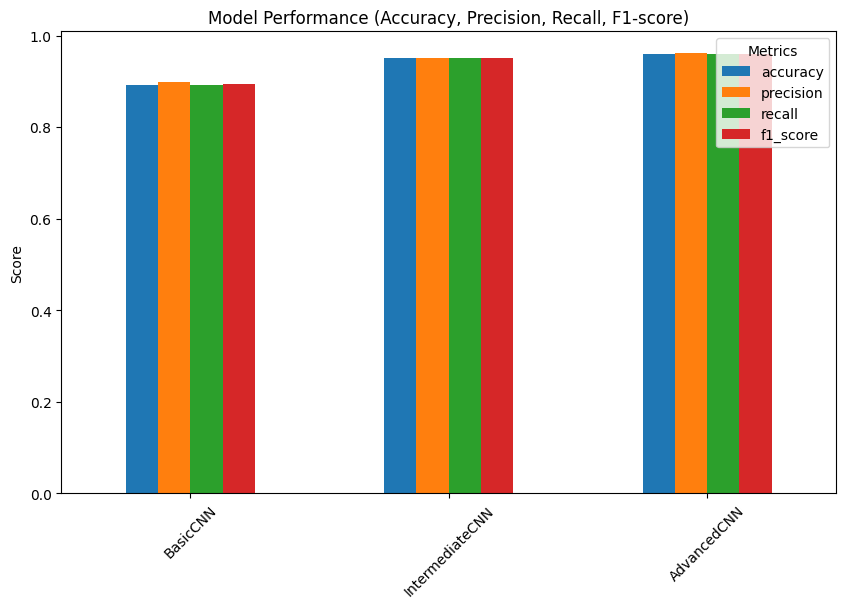

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 모델 평가 함수
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
        "f1_score": f1_score(y_true, y_pred, average="weighted"),
    }

# 모델 목록
models = {
    "BasicCNN": BasicCNN(),
    "IntermediateCNN": IntermediateCNN(),
    "AdvancedCNN": AdvancedCNN()
}

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델별 성능 저장할 딕셔너리
metrics = {}

# 학습된 모델 가중치 불러와 평가
for name, model in models.items():
    model.to(device)
    weight_path = f"{name}_best.pth"

    if os.path.exists(weight_path):  # 가중치 파일이 존재하면 로드
        model.load_state_dict(torch.load(weight_path, map_location=device))
        print(f" {name} 모델 가중치 로드 완료!")
        metrics[name] = evaluate_model(model, val_loader, device)
    else:
        print(f" {name}_best.pth 파일이 없습니다. 평가를 건너뜁니다.")

# DataFrame으로 변환
df_metrics = pd.DataFrame.from_dict(metrics, orient="index")

# 평가 결과 출력
print(df_metrics)

# CSV 파일로 저장
df_metrics.to_csv("model_metrics.csv", index=True)
print(" 모델 평가 결과가 'model_metrics.csv' 파일로 저장되었습니다.")

# 성능 시각화
if not df_metrics.empty:
    df_metrics.plot(kind="bar", figsize=(10, 6))
    plt.title("Model Performance (Accuracy, Precision, Recall, F1-score)")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics")
    plt.show()
else:
    print(" 모델 평가 결과가 없습니다.")


# 모델 성능 평가 결과 해석

## **1. 모델별 성능 비교**
| 모델              | 정확도 (Accuracy) | 정밀도 (Precision) | 재현율 (Recall) | F1-Score |
|------------------|----------------|-----------------|---------------|----------|
| **BasicCNN**         | 89.23%  | 89.88%  | 89.23%  | 89.32%  |
| **IntermediateCNN**  | 95.10%  | 95.16%  | 95.10%  | 95.13%  |
| **AdvancedCNN**      | 96.01%  | 96.08%  | 96.01%  | 96.03%  |

## **2. 성능 분석**
- **BasicCNN**  
  - 가장 기본적인 CNN 모델로, 정확도(89.23%)와 F1-score(89.32%)가 가장 낮음.
  - 모델이 비교적 단순하여 데이터의 복잡한 패턴을 충분히 학습하지 못한 것으로 보임.

- **IntermediateCNN**  
  - 모델의 깊이가 증가하면서 성능이 향상됨.
  - 정확도(95.10%)와 F1-score(95.13%)가 BasicCNN보다 크게 증가.
  - 더 많은 합성곱 레이어와 뉴런이 추가되어 데이터의 특징을 더 효과적으로 학습함.

- **AdvancedCNN**  
  - 가장 깊은 모델이며, 성능이 가장 우수함.
  - 정확도(96.01%), 정밀도(96.08%), 재현율(96.01%) 모두 최고.
  - 복잡한 구조 덕분에 데이터의 다양한 패턴을 더 정밀하게 학습할 수 있음.

## **3. 결론**
- 모델의 깊이가 증가할수록 성능이 향상됨.  
- **AdvancedCNN**이 가장 높은 성능을 기록했으므로, 최적의 모델로 선택하는 것이 바람직함.  
- **IntermediateCNN**도 성능이 우수하므로, 계산 비용이 부담된다면 이 모델을 고려할 수도 있음.  
- 만약 추가적인 성능 향상이 필요하다면, 데이터 증강(Augmentation)이나 학습률 조정, 하이퍼파라미터 튜닝 등을 시도해볼 수 있음.
